### Get `preference weight` based on `feature function`

In [1]:
#%%
import os
import sys
import re
import numpy as np
import matplotlib.pyplot as plt
import openai
import argparse

def extract_number(filename):
    # Extract the number from the filename using regular expression
    match = re.search(r'(\d+)', filename)
    return int(match.group()) if match else float('inf')

interaction_accuracy_list = []
preference_list = []
token_list = []
image_token_list = []
response_error_count = 0

#%%
# path = '../../dataset/block-and-bowl-scene/stack/'
path = '../../dataset/block-and-bowl-scene/color/'
# path = '../../dataset/block-and-bowl-scene/shape/'
folders = sorted(os.listdir(path), key=lambda x: int(x.split('.')[0]))
print(folders)
print(len(folders))

for folder in folders:
    interaction_accuracy = None
    preference_accuracy = None

    images = []
    color_folder_path = os.path.join(path, folder)
    # Filter filenames that start with 'rgb_'
    rgb_filenames = [f for f in os.listdir(color_folder_path) if f.startswith('rgb_')]
    interaction_info_path = [f for f in os.listdir(color_folder_path) if f.startswith('interaction_info')]
    # Sort it with ends_with number
    sorted_rgb_filenames = sorted(rgb_filenames, key=extract_number)
    # print(sorted_rgb_filenames)
    for rgb_index, sorted_rgb in enumerate(sorted_rgb_filenames):
        path_local = os.path.join(color_folder_path, sorted_rgb)
        images.append(path_local)
    
    break

['5', '15', '16', '25', '26', '27', '32', '40', '41', '56', '58', '69', '70', '73', '75', '78', '79', '80', '81', '83', '89', '92', '93', '94', '99', '101', '109', '111', '113', '116', '117', '122', '123', '128', '129', '133', '134', '135', '139', '140', '142', '145', '148', '151', '158', '159', '161', '167', '169', '175', '176', '179']
52


In [16]:
import numpy as np

def parse_color_shape(obj_name):
    """
        Parse color and shape from object name
    """
    parts = obj_name.split('_')
    return parts[2], parts[1]  # (color, shape)

def calculate_shape_distance(coord1, coord2, threshold=0.15):
    """
    Calculate the distance between two coordinates for shape preference.
    Consider the distance only if it's within a certain threshold.
    """
    distance = np.linalg.norm(coord1 - coord2)
    return distance if distance < threshold else np.inf

# def calculate_stacking(sequence, xy_threshold=0.05, z_threshold=0.03):
def calculate_stacking(sequence, xy_threshold=0.05, z_threshold=0.015):
    """
        Check if objects are stacked, return the number of stacked objects.
        Stacking is defined as objects being close in x, y coordinates and differing in z coordinate by a threshold.
    """
    x_coords, y_coords, z_coords = sequence[:, 0], sequence[:, 1], sequence[:, 2]
    num_objects = len(sequence)
    stacked = np.zeros(num_objects, dtype=bool)

    for i in range(num_objects):
        for j in range(i + 1, num_objects):
            x_close = np.abs(x_coords[i] - x_coords[j]) < xy_threshold
            y_close = np.abs(y_coords[i] - y_coords[j]) < xy_threshold
            z_diff = np.abs(z_coords[i] - z_coords[j]) > z_threshold
            if x_close and y_close and z_diff:
                stacked[i] = stacked[j] = True
    return np.sum(stacked) //2

def calculate_distance(coord1, coord2):
    """
        Calculate the distance between two coordinates
    """
    return np.linalg.norm(coord1 - coord2)

def normalize(value, min_value, max_value):
    """
        Normalize a value between 0 and 1
    """
    return (value - min_value) / (max_value - min_value)

interaction_info = np.load(os.path.join(color_folder_path, interaction_info_path[0]), allow_pickle=True)
# interaction_info.files
obj_names = interaction_info["obj_names"]
obj_positions = interaction_info["obj_positions"]

# Calculate weights for each sequence
for seq_idx, sequence in enumerate(obj_positions):
    color_distances, shape_distances = {}, {}
    stacking_count = calculate_stacking(sequence)
    # print(f"stacking_count: {stacking_count}")

    # Compute distances between each pair of objects
    for i in range(len(obj_names)):
        for j in range(i + 1, len(obj_names)):
            obj1, obj2 = obj_names[i], obj_names[j]
            distance = calculate_distance(sequence[i], sequence[j])
            color1, shape1 = parse_color_shape(obj1)
            color2, shape2 = parse_color_shape(obj2)
            if color1 == color2:
                color_distances.setdefault(color1, []).append(distance)
            if shape1 == shape2:
                shape_distances.setdefault(shape1, []).append(distance)

    # Compute average distances for color and shape
    average_color_distance = np.mean([np.mean(distances) for distances in color_distances.values()])
    average_shape_distance = np.mean([np.mean(distances) for distances in shape_distances.values()])
    average_color_distance = average_color_distance if average_color_distance != 0 else 1e-6 # numerical stability
    average_shape_distance = average_shape_distance if average_shape_distance != 0 else 1e-6 # numerical stability

    # Compute maximum and minimum values for normalization
    max_distance = max([max(v) if v else 1 for v in color_distances.values()] + [max(v) if v else 1 for v in shape_distances.values()], default=1)
    min_distance = min([min(v) if v else 0 for v in color_distances.values()] + [min(v) if v else 0 for v in shape_distances.values()], default=0)

    # Normalize color and shape distances (lower distance = higher preference)
    normalized_color_weight = 1 - normalize(average_color_distance, min_distance, max_distance)
    normalized_shape_weight = 1 - normalize(average_shape_distance, min_distance, max_distance)
    normalized_stacking_weight = normalize(stacking_count, 0, 3)

    # Determine preferred attribute
    preferred = max(("color", normalized_color_weight),
                    ("shape", normalized_shape_weight),
                    ("stack", normalized_stacking_weight),
                    key=lambda x: x[1])

    # print(normalized_color_weight, normalized_shape_weight, normalized_stacking_weight)
    print(f"seq_idx: {seq_idx}")
    print(f"   w_color: {normalized_color_weight:.4f}")
    print(f"   w_shape: {normalized_shape_weight:.4f}")
    print(f"   w_stacking: {normalized_stacking_weight:.4f}")
    if preferred[1] > 0.7:
        print(f"   preferred attribute: {preferred[0]} with its weight: {preferred[1]:.4f}")
    else:
        print(f"   preferred attribute: None")
# print(f"The preferred attribute is: {preferred[0]} with normalized weight: {preferred[1]:.4f}")


seq_idx: 0
   w_color: 0.1395
   w_shape: 0.7037
   w_stacking: 0.0000
   preferred attribute: shape with its weight: 0.7037
seq_idx: 1
   w_color: 0.0894
   w_shape: 0.5568
   w_stacking: 0.3333
   preferred attribute: None
seq_idx: 2
   w_color: 0.1922
   w_shape: 0.6711
   w_stacking: 0.3333
   preferred attribute: None
seq_idx: 3
   w_color: 0.1506
   w_shape: 0.7222
   w_stacking: 0.6667
   preferred attribute: shape with its weight: 0.7222
seq_idx: 4
   w_color: 0.0066
   w_shape: 0.9029
   w_stacking: 1.0000
   preferred attribute: stack with its weight: 1.0000


(5, 1200, 1920, 4)


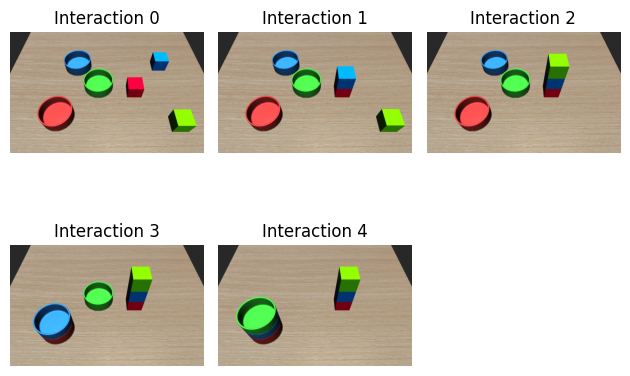

In [17]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

imgs_list = []
for image in images:
    img = plt.imread(image)
    imgs_list.append(img)
imgs_np = np.array(imgs_list)
print(imgs_np.shape)

N = imgs_np.shape[0]
cols = 3
rows = int(math.ceil(N / cols))

gs = gridspec.GridSpec(rows, cols)
fig = plt.figure()
for n in range(N):
    # title
    ax = fig.add_subplot(gs[n])
    ax.set_title(f"Interaction {n}")
    ax.imshow(imgs_np[n])
    ax.axis('off')
fig.tight_layout()
plt.show()


### Evaluation for 10 times

In [18]:
#%%
import os
import sys
import re
import numpy as np
import matplotlib.pyplot as plt
import openai
import argparse

def extract_number(filename):
    # Extract the number from the filename using regular expression
    match = re.search(r'(\d+)', filename)
    return int(match.group()) if match else float('inf')

interaction_accuracy_list = []
preference_list = []
token_list = []
image_token_list = []
response_error_count = 0

#%%
objective = 'color' # 'color' or 'shape' or 'stack'
dataset_path = '../../dataset/block-and-bowl-scene/'
path = os.path.join(dataset_path, objective)
folders = sorted(os.listdir(path), key=lambda x: int(x.split('.')[0]))
print(folders)
print(len(folders))

result_preference = []
for iter_idx, folder in enumerate(folders):
    interaction_accuracy = None
    preference_accuracy = None

    images = []
    color_folder_path = os.path.join(path, folder)
    # Filter filenames that start with 'rgb_'
    rgb_filenames = [f for f in os.listdir(color_folder_path) if f.startswith('rgb_')]
    interaction_info_path = [f for f in os.listdir(color_folder_path) if f.startswith('interaction_info')]
    # Sort it with ends_with number
    sorted_rgb_filenames = sorted(rgb_filenames, key=extract_number)
    # print(sorted_rgb_filenames)
    for rgb_index, sorted_rgb in enumerate(sorted_rgb_filenames):
        path_local = os.path.join(color_folder_path, sorted_rgb)
        images.append(path_local)
    
    interaction_info = np.load(os.path.join(color_folder_path, interaction_info_path[0]), allow_pickle=True)
    obj_names = interaction_info["obj_names"]
    obj_positions = interaction_info["obj_positions"]

    # Calculate weights for each sequence
    for seq_idx, sequence in enumerate(obj_positions):
        color_distances, shape_distances = {}, {}
        stacking_count = calculate_stacking(sequence)
        # print(f"stacking_count: {stacking_count}")

        # Compute distances between each pair of objects
        for i in range(len(obj_names)):
            for j in range(i + 1, len(obj_names)):
                obj1, obj2 = obj_names[i], obj_names[j]
                distance = calculate_distance(sequence[i], sequence[j])
                color1, shape1 = parse_color_shape(obj1)
                color2, shape2 = parse_color_shape(obj2)
                if color1 == color2:
                    color_distances.setdefault(color1, []).append(distance)
                if shape1 == shape2:
                    shape_distances.setdefault(shape1, []).append(distance)

        # Compute average distances for color and shape
        average_color_distance = np.mean([np.mean(distances) for distances in color_distances.values()])
        average_shape_distance = np.mean([np.mean(distances) for distances in shape_distances.values()])
        average_color_distance = average_color_distance if average_color_distance != 0 else 1e-6 # numerical stability
        average_shape_distance = average_shape_distance if average_shape_distance != 0 else 1e-6 # numerical stability

        # Compute maximum and minimum values for normalization
        max_distance = max([max(v) if v else 1 for v in color_distances.values()] + [max(v) if v else 1 for v in shape_distances.values()], default=1)
        min_distance = min([min(v) if v else 0 for v in color_distances.values()] + [min(v) if v else 0 for v in shape_distances.values()], default=0)

        # Normalize color and shape distances (lower distance = higher preference)
        normalized_color_weight = 1 - normalize(average_color_distance, min_distance, max_distance)
        normalized_shape_weight = 1 - normalize(average_shape_distance, min_distance, max_distance)
        normalized_stacking_weight = normalize(stacking_count, 0, 3)

        # Determine preferred attribute
        preferred = max(("color", normalized_color_weight),
                        ("shape", normalized_shape_weight),
                        ("stack", normalized_stacking_weight),
                        key=lambda x: x[1])

        # print(normalized_color_weight, normalized_shape_weight, normalized_stacking_weight)
        print(f"seq_idx: {seq_idx}")
        print(f"   w_color: {normalized_color_weight:.4f}")
        print(f"   w_shape: {normalized_shape_weight:.4f}")
        print(f"   w_stacking: {normalized_stacking_weight:.4f}")
    if preferred[1] > 0.7:
        print(f"[{iter_idx}/{len(folders)}] preferred attribute: {preferred[0]} with its weight: {preferred[1]:.4f}")
        result_preference.append(preferred[0])
        # print(f"   preferred attribute: {preferred[0]} with its weight: {preferred[1]:.4f}")
    else:
        print(f"   preferred attribute: None")
    # print(f"The preferred attribute is: {preferred[0]} with normalized weight: {preferred[1]:.4f}")


['5', '15', '16', '25', '26', '27', '32', '40', '41', '56', '58', '69', '70', '73', '75', '78', '79', '80', '81', '83', '89', '92', '93', '94', '99', '101', '109', '111', '113', '116', '117', '122', '123', '128', '129', '133', '134', '135', '139', '140', '142', '145', '148', '151', '158', '159', '161', '167', '169', '175', '176', '179']
52
seq_idx: 0
   w_color: 0.4969
   w_shape: 0.4547
   w_stacking: 0.0000
seq_idx: 1
   w_color: 0.6946
   w_shape: 0.3339
   w_stacking: 0.0000
seq_idx: 2
   w_color: 0.9292
   w_shape: 0.2494
   w_stacking: 0.0000
seq_idx: 3
   w_color: 1.0000
   w_shape: 0.1871
   w_stacking: 0.0000
[0/52] preferred attribute: color with its weight: 1.0000
seq_idx: 0
   w_color: 0.3975
   w_shape: 0.6833
   w_stacking: 0.0000
seq_idx: 1
   w_color: 0.6632
   w_shape: 0.4181
   w_stacking: 0.0000
seq_idx: 2
   w_color: 0.9104
   w_shape: 0.1606
   w_stacking: 0.0000
seq_idx: 3
   w_color: 1.0000
   w_shape: 0.0969
   w_stacking: 0.0000
[1/52] preferred attribute: colo

In [19]:
from collections import Counter

# Counting the occurrences of each unique element
element_counts = Counter(result_preference)

# Extracting counts for "color", "shape", and "stack"
color_count = element_counts['color']
shape_count = element_counts['shape']
stack_count = element_counts['stack']

color_count, shape_count, stack_count

(52, 0, 0)

In [20]:
result_preference_accuracy = element_counts[objective] / len(result_preference)
print(f"result_preference_accuracy: {result_preference_accuracy}")

result_preference_accuracy: 1.0


: 

In [13]:
np.array(result_preference), len(result_preference)

(array(['stack', 'stack', 'stack', 'stack', 'stack', 'stack', 'stack',
        'stack', 'stack', 'stack', 'stack', 'stack', 'stack', 'stack',
        'stack', 'stack', 'stack', 'stack', 'stack', 'stack', 'stack',
        'stack', 'stack', 'stack', 'stack', 'stack', 'stack', 'stack',
        'stack', 'stack', 'stack', 'stack', 'stack', 'stack', 'stack',
        'stack', 'stack', 'stack', 'stack', 'stack', 'stack', 'stack',
        'stack', 'stack', 'stack', 'stack', 'stack', 'stack', 'stack',
        'stack', 'stack', 'stack', 'stack', 'stack', 'stack', 'stack',
        'stack', 'stack', 'stack', 'stack', 'stack', 'stack', 'stack',
        'stack', 'stack'], dtype='<U5'),
 65)

In [14]:
interaction_info = np.load(os.path.join(color_folder_path, interaction_info_path[0]), allow_pickle=True)
color_folder_path

'../../dataset/block-and-bowl-scene/stack/180'

In [15]:
import numpy as np

true_preference = np.ones(65+23+36)
false_preference = np.zeros(17)
total_preference = np.concatenate((true_preference, false_preference))
total_preference.mean(), total_preference.std()

(0.8794326241134752, 0.3256238378226665)